# Introduction

### Research Problem

Handwriting Recognition is an old ML problem that is still not completely solved because of its complexity. Once properly set up, It can be used to digitize different types of documents like historical texts, patient prescriptions, bank records, etc. In our project, we will be focussing on how we can utilize this technique to help society. We decided to create an application that will help visually impaired people listen to handwritten notes.


## Why Is It Important?

Visually impaired people are dependent on other people to help them read handwritten notes. We want to make this task easier by providing an accessible application that would take an image of a handwritten note and convert it to lifelike speech. This will make it so the task can be done independently. Currently, there's no good free-to-use application that converts handwritten notes to audio. This project has a great social impact and can help many people struggling with accessibility.

## What Do We Know So Far? Who has done what?

The existing work includes image to sequence model (https://arxiv.org/pdf/2103.06450.pdf) which does not include image segmentation. The author here has trained the model to detect full pages of handwritten text using the Image to Sequence model which can extract text present in an image and then sequence it correctly without imposing any constraints regarding orientation, layout and size of text and non-text.  Another paper [[2112.13328] Continuous Offline Handwriting Recognition using Deep Learning Models](https://arxiv.org/abs/2112.13328) where handwriting recognition is done using deep learning uses a new recognition model based on integrating two types of deep learning architectures: convolutional neural networks (CNN) and sequence-to-sequence (seq2seq) models, respectively. The convolutional component of the model is oriented to identify relevant features present in characters, and the seq2seq component builds the transcription of the text by modeling the sequential nature of the text.  

Following the same deep learning technique another paper [Handwritten Text Recognition using Deep Learning](http://cs231n.stanford.edu/reports/2017/pdfs/810.pdf) talks about using CNN model for classifying words & LSTM model for character segmentation.  

For our project, we are using the IAM dataset, which already has many models built for handwriting recognition. However, we have not found any that also convert the text to speech. Some models that have been used include training the model on lines, words, and rarely also on characters. The character segmentation is a complex process to understand and replicate. Also, the use of deep learning techniques makes it difficult to interpret. 


## Knowledge Gap and Narrowing the Gap

There are many different handwriting styles and there is no perfect model that can convert handwriting to text. There are many models that have attempted to solve this problem using Convolutional Neural Networks (CNN) and Multidimensional Recurrent Neural Networks (RNN) and we are trying to find a better solution by testing these models against other traditional machine learning models like K-Nearest Neighbors (KNN), Random Forest, Naive Bayes and Support Vector Machines (SVM). 

Another important component of this project is converting handwritten text to life-like speech. At present, there is no such product that uses a voiceover to read texts. Our aim is to work on the text-to-speech conversion to build a better model. An issue with converting handwritten text to speech (TTS) is we want to avoid having a robotic voice relay the text, having the voice sound more human-like will be a big challenge. There are different libraries like AWS Poly and Watson TTS that we have used. 

## Purpose of the study

The sole purpose of this project is to test different traditional models that are not commonly used for handwriting recognition, as well as to try & test different TTS libraries. Since we are using handwritten notes, the first question was to extract & identify words from the full-page text image. The next step we needed to tackle was how we can use different models to recognize words from images and compare them to already existing methods.
 
Also, we are reassembling the words into the final text and converting the text into life-like speech. So the next question would be to define a voice for the final text.


# Methods and Materials

## Data Sources

The [IAM](https://fki.tic.heia-fr.ch/databases/iam-handwriting-database) Handwriting Database contains handwritten English text in various formats that can be used to train and test handwritten text recognizers. The database has documents that contain unconstrained handwritten text forms, scanned at a resolution of 300 dpi and saved as PNG images with 256 gray levels. The dataset contains 115,320 words contained in 1,539 pages of handwritten text, by 657 unique writers. The dataset offers handwriting pages, which have also been extracted into lines and words using an automatic segmentation scheme. We have decided to use the full pages of the handwritten notes as a dataset since that is the most similar to what we would be faced with, in a real-world use case.

Sample image:
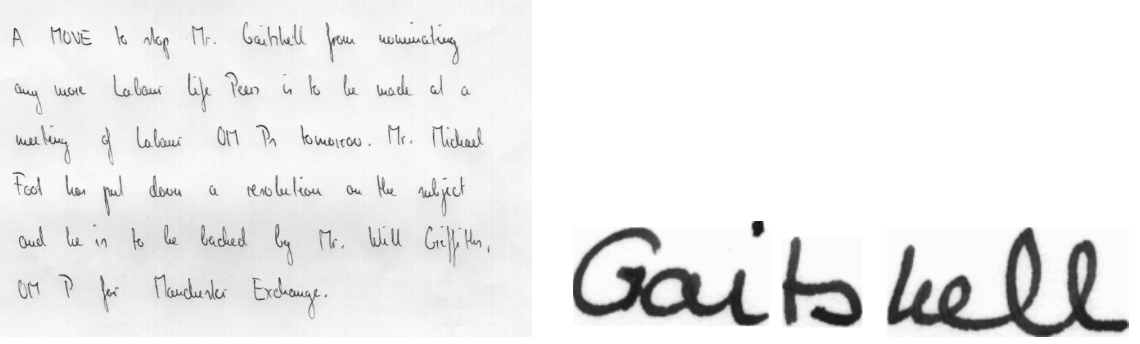

<font size = 5>Initial Setup</font>

In [1]:
%%capture
!rm -rf ml
# Using personal repo because 521 org private repo access is limited. We did not copy whole code in this repo, only the common functions. Main repo is
!git clone https://github.com/pal0064/ml


In [2]:
%%capture
!cd ml;make install-sys-packages
!cd ml;make install-python-packages
# restart runtime, some libraries need that.

In [1]:
# Download the dataset to google drive
# https://fki.tic.heia-fr.ch/databases/iam-handwriting-database

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<font size = 5>Download Dataset</font>

*  Create a folder in Google Drive named iam_dataset
*  Download all compressed iam files from [iam](https://fki.tic.heia-fr.ch/databases/iam-handwriting-database)
*  Upload all files to iam_dataset folder

In [2]:
%%capture
!cd ml; make download-data-from-google-drive

## Analysis

<font size=4> 
*   We used the existing word-segmented images from the dataset.  
*   We reduced the dataset size (because of limited resources)
  *   By using 1 of 2 approaches mentioned below
  *   By choosing a maximum number of images per word </font>

<font size=5>  Start Model Training </font>

In [3]:
import sys
sys.path.insert(1, "/content/ml/src/python")
from IPython.display import Audio
import numpy as np
from datasets.iam.labels_pre_processing import get_input_for_labels_based_max_size,get_images_and_labels,get_features_and_labels,get_input_for_labels_based_on_training_words,get_word 
from datasets.iam.predictions import recognize,get_word_count
import random
import easyocr
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tabulate import tabulate
from ml.model.models import get_gaussian_model, get_random_forest_model,get_knn_model,get_svm_model
from ml.model.model_exec import run_model, run_model_with_cv,get_predict_from_model, get_accuracy_score
from ml.model.performance.model_performance import get_performance_data
from ml.model.performance.visualization.model_peformance_viz import make_box_plots_for_models_performance_comparison, show_fig
from ml.model.tuning.hyper_param_tuning import tune_svm_model, show_tuned_model_performance
from processing.image.image_processing import read_image, show_image
from processing.audio.tts import convert_to_audio
import plotly
import plotly.io as pio

In [27]:

pio.renderers.default = "colab+notebook+pdf" 
np.random.seed(2022)
# Folder containing images of words
base_path_for_images = "/words"

# Text file containing info about images and words
file_path = "/words_label/words.txt"

<font size=4> Approach 1: Choosing the most common words from the dataset 
</font>

In [28]:
# Approach 1
# MAX_WORDS: Number of words to be included in the our dataset (takes n most common words)
MAX_WORDS = 50

<font size=4>
Approach 2: Choosing a list of handpicked words from the dataset </font>

In [29]:
# Approach 2
# TRAIN_WORDS: specific list of words that we will include in the dataset
TRAIN_WORDS = {'the', 'he', 'for', 'stop', 'on', 'Foot', 'Labour', 'at', 'Griffiths', 'and', 'of', 'by', 'any', '.', 'subject', 'Peers', 'tomorrow', 'nominating', 'has', 'Mr.', 'backed', 'MOVE', 'life', 'be', 'is', 'resolution', 'Ps', 'meeting', 'a', 'from', 'Michael', 'Gaitskell', 'more', 'put', 'Exchange', 'Manchester', 'to', 'down', 'Will', ',', 'made', 'P', 'A'}

In [30]:
# Choosing maximum number of images per word
MAX_IMAGES_PER_WORD = 200 

TEST_DATASET_SIZE = 0.05 # portion of dataset we will use in test set
NORMALIZE_SCALE = 255.0 # normalizing pixels for all the images
IMAGE_SIZE = (128,128) # to resize words to same dimensions
METRICS = {}

<font size=4> Mapping the image to the label of the selected word </font>


In [31]:
# APPROACH 1 (Max words)
# input_for_labels = get_input_for_labels_based_max_size(file_path,max_words=MAX_WORDS,max_images_per_word=MAX_IMAGES_PER_WORD)


In [32]:
# APPROACH 2 (List of words)
input_for_labels = get_input_for_labels_based_on_training_words(file_path,TRAIN_WORDS,MAX_IMAGES_PER_WORD)

<font size=4> Image Processing
*   We read the image in grayscale. 
*   We resize all images to a fixed size 
*   We converted each image to an array and normalized it.
</font>

<font size=4> Bounding Boxes for Word Detection
*   Each line is detected by dilation technique
*   Within each line, each word is detected
</font>


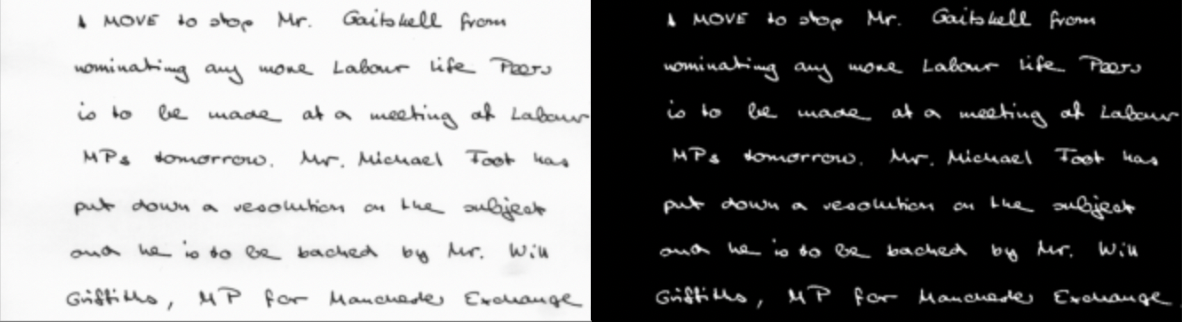

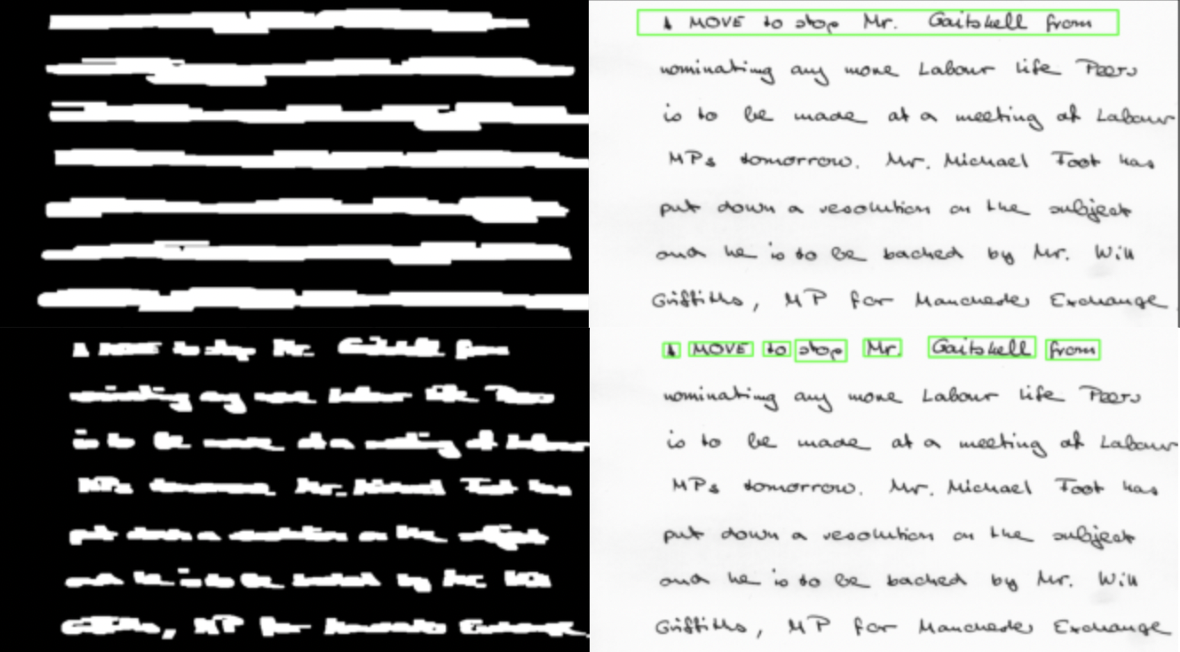

In [33]:
input_data = get_images_and_labels(base_path_for_images, input_for_labels, IMAGE_SIZE)

random.shuffle(input_data)

<font size=4> We encoded the labels to map each label to a number </font>

In [34]:
label_encoder = LabelEncoder()
features,labels = get_features_and_labels(input_data,label_encoder)

<font size = 4>Training and testing split</font>

In [35]:
x_train,x_test,y_train,y_test = train_test_split(features,labels,
                                                 test_size=TEST_DATASET_SIZE)

x_train_unscaled,x_test_unscaled,features_unscaled = x_train,x_test,features
x_train,x_test = x_train/NORMALIZE_SCALE,x_test/NORMALIZE_SCALE

features = features/NORMALIZE_SCALE

In [36]:
w_train = len(set(y_train.tolist())) # number of words in train set
w_test = len(set(y_test.tolist())) # number of words in test set
i_train = len(y_train.tolist()) # number of images in train set
i_test = len(y_test.tolist()) # number of images in test set

data = [["Training Set",i_train,w_train],["Test Set",i_test,w_test]]
print(tabulate(data, headers=["", "Number of images", "Number of words"]))

                Number of images    Number of words
------------  ------------------  -----------------
Training Set                4063                 40
Test Set                     214                 30


We trained the dataset using the K cross-validation method with k=5 with different models:

*   Naive Bayes
  *   Gaussian
  *   Multinomial

In [37]:
results = None
model_names = [
      'GaussianNB',
      'MultinomialNB'
]
for model_name in model_names:
  nb_model = get_gaussian_model(model_name)
  results = run_model(nb_model,x_train, y_train,x_test,y_test,model_name)
  METRICS[model_name] = run_model_with_cv(model_name,nb_model,x_train, y_train)
  print("\n\n")
  final_model = nb_model

Training time: 0 mins 2 sec
Model: GaussianNB 
Using: Train/Test Split 
Accuracy: 57%

CV Training time: 1 mins 17 sec
Model:  GaussianNB
Using:  5 -fold cross validation
Score      Training    Validation
---------  ----------  ------------
Accuracy   65%         56%
Precision  69%         62%
Recall     65%         56%
F1         64%         56%



Training time: 0 mins 0 sec
Model: MultinomialNB 
Using: Train/Test Split 
Accuracy: 62%

CV Training time: 0 mins 5 sec
Model:  MultinomialNB
Using:  5 -fold cross validation
Score      Training    Validation
---------  ----------  ------------
Accuracy   67%         61%
Precision  70%         66%
Recall     67%         61%
F1         68%         62%





*   K Nearest Neighbors
  *   k = 5
  *   p=2 Euclidean Distance

In [38]:
model_name = 'KNN'
knn_model = get_knn_model()
run_model(knn_model,x_train, y_train,x_test,y_test,model_name)
METRICS[model_name] = run_model_with_cv(model_name,knn_model,x_train, y_train)

Training time: 0 mins 0 sec
Model: KNN 
Using: Train/Test Split 
Accuracy: 71%

CV Training time: 0 mins 56 sec
Model:  KNN
Using:  5 -fold cross validation
Score      Training    Validation
---------  ----------  ------------
Accuracy   79%         67%
Precision  83%         73%
Recall     79%         67%
F1         79%         66%


*   Random Forest
  *   Number of trees = 100	

In [39]:
model_name = 'Random Forest'
rf_model = get_random_forest_model()
run_model(rf_model,x_train_unscaled, y_train,x_test_unscaled,y_test,model_name)
METRICS[model_name] = run_model_with_cv(model_name,rf_model,x_train_unscaled, y_train)

Training time: 0 mins 37 sec
Model: Random Forest 
Using: Train/Test Split 
Accuracy: 73%

CV Training time: 2 mins 36 sec
Model:  Random Forest
Using:  5 -fold cross validation
Score      Training    Validation
---------  ----------  ------------
Accuracy   100%        74%
Precision  100%        76%
Recall     100%        74%
F1         100%        72%


*   Support Vector Machines
  *   Poly kernel with Degree 3

In [40]:
model_name = 'SVM Poly'
svm_poly = get_svm_model()
run_model(svm_poly,x_train, y_train,x_test,y_test,model_name)
METRICS[model_name]  = run_model_with_cv(model_name,svm_poly,x_train, y_train)

Training time: 2 mins 23 sec
Model: SVM Poly 
Using: Train/Test Split 
Accuracy: 81%

CV Training time: 20 mins 28 sec
Model:  SVM Poly
Using:  5 -fold cross validation
Score      Training    Validation
---------  ----------  ------------
Accuracy   100%        77%
Precision  100%        78%
Recall     100%        77%
F1         100%        76%


In [41]:
# tuning using bayesian optimization
final_model = tune_svm_model(x_train,y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



# Results

In [42]:
performance_df = get_performance_data(METRICS)
performance_df.head(10)

model_name    fit_time  score_time  test_accuracy  train_accuracy  \
0       SVM Poly   94.785535   27.880433       0.752768        0.999385   
1       SVM Poly  103.129050   29.430198       0.739237        0.999692   
2       SVM Poly   99.588099   28.269174       0.773678        1.000000   
3       SVM Poly   91.350872   34.233665       0.773399        0.999692   
4       SVM Poly  102.283377   28.029816       0.801724        0.999692   
5  Random Forest   29.678700    0.109339       0.740467        0.999692   
6  Random Forest   29.541366    0.104445       0.720787        1.000000   
7  Random Forest   29.739092    0.102699       0.752768        1.000000   
8  Random Forest   35.137243    0.107289       0.725369        0.999692   
9  Random Forest   29.673220    0.102428       0.752463        0.999692   

    test_f1  train_f1  test_precision  train_precision  test_recall  \
0  0.748390  0.999385        0.767978         0.999389     0.752768   
1  0.733072  0.999692        0.756133         0.999694     0.739237   
2  0.766208  1.000000        0.783222         1.000000     0.773678   
3  0.765465  0.999692        0.787177         0.999695     0.773399   
4  0.796604  0.999692        0.811073         0.999694     0.801724   
5  0.724363  0.999692        0.760075         0.999694     0.740467   
6  0.703407  1.000000        0.742881         1.000000     0.720787   
7  0.735750  1.000000        0.773492         1.000000     0.752768   
8  0.708407  0.999692        0.750114         0.999695     0.725369   
9  0.733664  0.999692        0.761697         0.999694     0.752463   

   train_recall  
0      0.999385  
1      0.999692  
2      1.000000  
3      0.999692  
4      0.999692  
5      0.999692  
6      1.000000  
7      1.000000  
8      0.999692  
9      0.999692

In [43]:
# Accuracy Comparison
fig = make_box_plots_for_models_performance_comparison(performance_df,['train_accuracy','test_accuracy'],'Accuracy')
show_fig(fig)

In [44]:
fig.show() #for exporting to pdf & local pynb

In [45]:
# Precision Comparison
fig=make_box_plots_for_models_performance_comparison(performance_df,['train_precision','test_precision'],'Precision')
show_fig(fig)

In [46]:
fig.show() #for exporting to pdf & local pynb

In [47]:
# Recall Comparison
fig = make_box_plots_for_models_performance_comparison(performance_df,['train_recall','test_recall'],'Recall')
show_fig(fig)

In [48]:
fig.show() #for exporting to pdf & local pynb

In [49]:
# F1 Score Comparison
fig = make_box_plots_for_models_performance_comparison(performance_df,['train_f1','test_f1'],'F1 Score')
show_fig(fig)

In [50]:
fig.show() #for exporting to pdf & local pynb

In [51]:
# Score Time and Fit Time Comparison
fig = make_box_plots_for_models_performance_comparison(performance_df,['score_time','fit_time'],'Score Time & Fit Time')
show_fig(fig)

In [52]:
fig.show() #for exporting to pdf & local pynb

In [53]:
# SVM model peformance after hyperparameter tuning
show_tuned_model_performance(final_model,x_test,y_test)

test score: 0.8130841121495327
val. score: 0.7792352110713224
best params: OrderedDict([('C', 5.87540411933884e-05), ('degree', 6), ('gamma', 0.001948086705393068), ('kernel', 'poly')])


# Discussion

*  We can use an image to sequence model which does not use image segmentation.
Replicating [Full Page Handwriting Recognition via Image to
Sequence Extraction](https://arxiv.org/pdf/2103.06450.pdf)

*   We need lots of words images - hard to obtain these images and make sure every word is included, and then it would be computationally expensive to train the model

*   All the life-like speech libraries are paid

*   Traditional ML models do not work really well

## Demo

<font size=4> For the demo, we did word segmentation of the image using Opencv (bounding box) and predicted the text using the best model (SVM) </font>

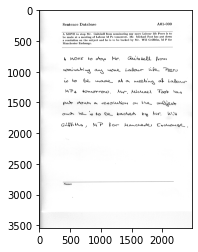

In [54]:
image_path = '/forms/a01-000u.png'
show_image(read_image(image_path))

Using Human like voice

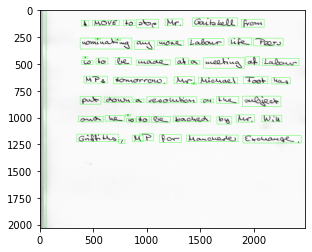

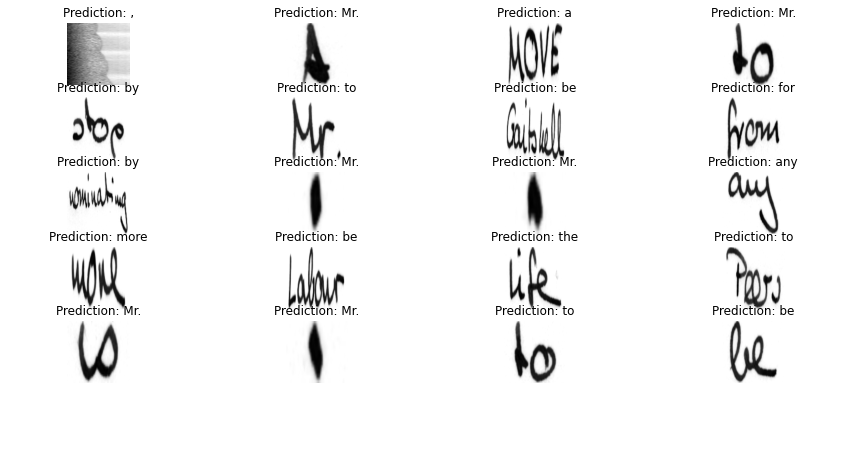

, Mr. a Mr. by to be for by Mr. Mr. any more be the to Mr. Mr. to be A of , by he be life he to Mr. he to the for be , be , the subject at the Mr. , he be be by to made A Mr. , , for made for


In [55]:
# Using Google Text to Speech engine
sound_file,predictions = recognize(final_model,label_encoder,image_path,IMAGE_SIZE,NORMALIZE_SCALE,show_sample=20,forms=True,engine_type='gtts') 
print(" ".join(predictions))
Audio(sound_file, autoplay=False)
# Not so good prediction because we don't have enough training images for some words

<font size = 5>Using Human like voice

Using AWS Polly engine <br>
To use AWS Polly, we need AWS Credentials (Access Key, Secret Key).<br>
Upload aws Credentials profile file to root directory of the project. <br>

File name should be **aws_credentials**.<br>

sample content of file:<br>
[default]<br>
aws_access_key_id = AAAAAAA<br>
aws_secret_access_key = BBBB

In [ ]:
# # Once you have uploaded the credentials, uncomment the code below

# sound_file,predictions = recognize(final_model,label_encoder,image_path,IMAGE_SIZE,NORMALIZE_SCALE,show_sample=10,forms=True,engine_type='polly') #use polly or gtts for aws polly
# print(" ".join(predictions))
# Audio(sound_file, autoplay=False)

In [ ]:
# Sample of using polly Text To Speech engine

# text = ['Hi','Cristian','I', 'am', 'Justin', '.', 'Congrats','on','being', 'nominated', 'for', 'afrocoloumbian', 'of', 'the', 'year', '2022']
# Audio(convert_to_audio(text, engine_type='polly'))

Trying python package on same image

In [56]:
%%capture
# Trying easyocr library

reader = easyocr.Reader(['en'],gpu = False) # load once only in memory.
image = read_image(image_path, forms=True)

r_easy_ocr = reader.readtext(image,detail=0)

In [57]:
" ".join(r_easy_ocr)

'MOVE Ar . Gaibsbe Q& Gvom wminal-g Lone_ Labaur Lfe_ L Qsq_ Luade_ al 0 ak Lalau M? g donorrosl Mv , Muclae ( Toot haA Puk @uJl 0 vejoluboM ON Lae _ suQieak 040 Wq _ 0 #0 QQ _ baclea Ar; W;u Gwckls 4?P Pom Mancuosles Exollauqr_ 3o0 4o Pot) ax Lo ieoHna 64'

## Limitations

We have limited computational resources. Since we are training the model on images of words, the dataset used has a limited number of words. It doesn’t include every word in the English language, with all their variations, and some of the included words may have as little as one image. Finding a complete dataset would be near to impossible. 

## Future Work

Traditional machine learning models do not perform well so using Neural network models can probably increase the performance. For image segmentation to work well, we need to have a large inclusive dataset of words, which is hard to achieve, so instead we can use Image to Sequence architecture. In our project, we have given a voiceover to read the final text. Emotions are important when you are reading something to make it clear like sad, happy or excited. Introducing emotions to words can be a wide aspect to look at. Also, the handwritten text can not always make sense to the models like when working with different handwriting styles or coming across spelling mistakes, typos. We can always take a look at the large & synthetic datasets to work on more images.

# Conclusion

We did handwriting recognition using different traditional models and image segmentation. The model with the best performance was Support Vector Machines. This model is easy to replicate and makes it easy to understand. Considering the performance, traditional ML models do not outperform Neural Networks. The image segmentation approach requires a lot of training data for each word, in order to predict accurately. It does not perform well when the data changes for e.g. curved text, change in height and width, and formatting and indentation is not always preserved. So, Image to Sequence architecture with Neural Networks implementation seems to be a better method, however it may not be as easily replicated as it is more complex and requires more computational costs. 